Final classes: ['Bridge', 'CMP', 'VIA', 'Other', 'Crack', 'Particle', 'Clean', 'Open', 'LER']
Input Shape: ['s77', 3, 224, 224]
Output Shape: [1, 12]
ONNX model loaded


LER: 100%|██████████| 30/30 [00:00<00:00, 42.27it/s]


Predictions finished
Accuracy: 30.41 %

Classification Report

              precision    recall  f1-score   support

      Bridge       0.41      0.69      0.51        32
         CMP       0.00      0.00      0.00        30
       Clean       0.07      0.09      0.08        33
       Crack       0.52      0.52      0.52        31
         LER       0.86      0.60      0.71        30
        Open       0.34      0.43      0.38        30
       Other       0.22      0.07      0.11        80
         VIA       0.50      0.40      0.44        30

    accuracy                           0.30       296
   macro avg       0.36      0.35      0.34       296
weighted avg       0.34      0.30      0.30       296

Log file saved as inference_log.txt


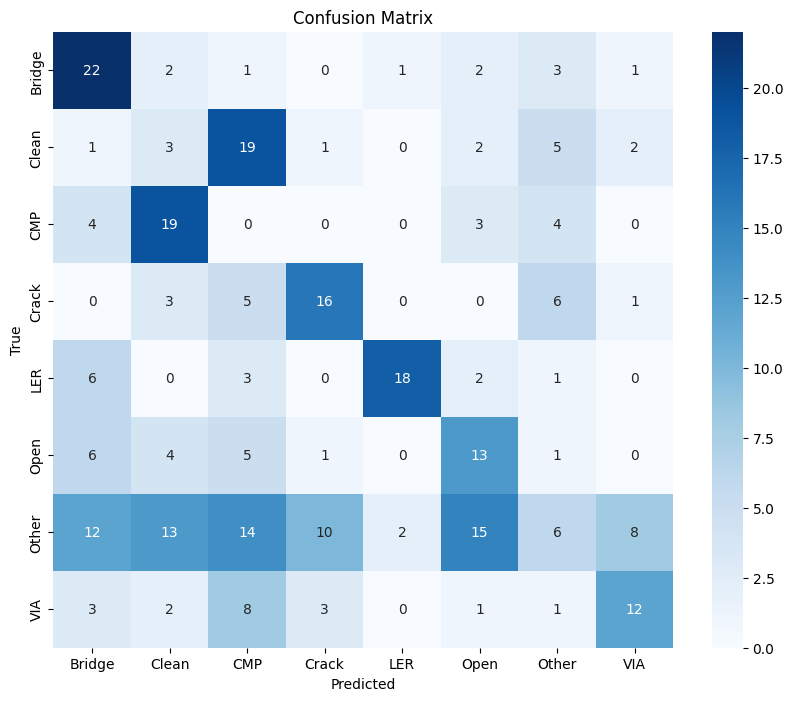

In [7]:
import logging

logging.basicConfig(
    filename="evaluation_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(message)s"
)

# ================================
# STEP 1 — Install
# ================================
!pip install -q onnxruntime opencv-python-headless scikit-learn tqdm matplotlib seaborn

# ================================
# STEP 2 — Imports
# ================================
import os, zipfile, shutil
import cv2
import numpy as np
import onnxruntime as ort
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# STEP 3 — Extract Dataset
# ================================
if os.path.exists("hackathon_test_dataset"):
    shutil.rmtree("hackathon_test_dataset")

with zipfile.ZipFile("hackathon_test_dataset.zip","r") as z:
    z.extractall("hackathon_test_dataset")

base = "hackathon_test_dataset"
inner = os.path.join(base,"hackathon_test_dataset")

if os.path.exists(inner):
    for f in os.listdir(inner):
        shutil.move(os.path.join(inner,f),base)
    shutil.rmtree(inner)

print("Final classes:", os.listdir(base))

# ================================
# STEP 4 — Load ONNX Model
# ================================
session = ort.InferenceSession(
    "sem_mobilenetv2_model.onnx",
    providers=["CPUExecutionProvider"]
)

input_name  = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

print("Input Shape:", session.get_inputs()[0].shape)
print("Output Shape:", session.get_outputs()[0].shape)
print("ONNX model loaded")

# ================================
# STEP 5 — Model Class Order (TRAINED)
# ================================
model_classes = [
 'Bridge','Clean','CMP','Crackes','LER',
 'Missing patterns','Multiple defects in one image',
 'Open','Ripple','Scratch',
 'Stain and Edge Contamination','VIAS'
]

# ================================
# STEP 6 — Organizer Classes (FINAL EVAL SPACE)
# ================================
organizer_classes = [
 'Bridge','Clean','CMP','Crack','LER',
 'Open','Other','VIA'
]

# ================================
# STEP 7 — Label Mapping (12 → 9)
# ================================
def map_prediction(label):

    mapping = {
        "Bridge":"Bridge",
        "Clean":"Clean",
        "CMP":"CMP",
        "Crackes":"Crack",
        "LER":"LER",
        "Open":"Open",
        "VIAS":"VIA",

        # collapse rare defect types → Other
        "Missing patterns":"Other",
        "Multiple defects in one image":"Other",
        "Ripple":"Other",
        "Scratch":"Other",
        "Stain and Edge Contamination":"Other"
    }

    return mapping.get(label,"Other")

# ================================
# STEP 8 — Ground Truth Mapping
# ================================
def map_ground_truth(label):

    if label == "Particle":
        return "Other"

    if label == "Other":
        return "Other"

    return label

# ================================
# STEP 9 — Preprocessing (MATCH TRAINING)
# ================================
IMG_SIZE = 224

def preprocess(path):

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        return None

    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    img = img.astype(np.float32)/255.0

    # stack grayscale → 3 channels
    img = np.stack([img,img,img],axis=-1)

    mean = np.array([0.485,0.456,0.406],dtype=np.float32)
    std  = np.array([0.229,0.224,0.225],dtype=np.float32)

    img = (img-mean)/std
    img = np.transpose(img,(2,0,1))
    img = np.expand_dims(img,0)

    return img.astype(np.float32)

# ================================
# STEP 10 — Inference
# ================================
root = "hackathon_test_dataset"

y_true=[]
y_pred=[]

for true_class in os.listdir(root):

    class_dir=os.path.join(root,true_class)
    if not os.path.isdir(class_dir):
        continue

    for img_name in tqdm(os.listdir(class_dir),desc=true_class):

        path=os.path.join(class_dir,img_name)
        x=preprocess(path)

        if x is None:
            continue

        out=session.run([output_name],{input_name:x})[0]

        # NO SOFTMAX
        pred_idx = np.argmax(out[0])
        pred_label = model_classes[pred_idx]

        mapped_pred = map_prediction(pred_label)
        mapped_true = map_ground_truth(true_class)

        y_true.append(mapped_true)
        y_pred.append(mapped_pred)

print("Predictions finished")

# ================================
# STEP 11 — Metrics
# ================================
acc=accuracy_score(y_true,y_pred)
print("Accuracy:",round(acc*100,2),"%")

print("\nClassification Report\n")
print(classification_report(y_true,y_pred))

logging.info(f"Input shape: {session.get_inputs()[0].shape}")
logging.info(f"Output shape: {session.get_outputs()[0].shape}")
logging.info(f"Accuracy: {acc}")
logging.info(classification_report(y_true,y_pred))

# ================================
# STEP 11.1 — Save Log File
# ================================
with open("inference_log.txt","w") as f:
    f.write(f"Accuracy: {round(acc*100,2)} %\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_true,y_pred))

print("Log file saved as inference_log.txt")

# ================================
# STEP 12 — Confusion Matrix
# ================================
cm=confusion_matrix(y_true,y_pred,labels=organizer_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt="d",
            xticklabels=organizer_classes,
            yticklabels=organizer_classes,
            cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()